# MS-CELEB Face Recognition

## Importing the libraries


In [1]:
import os
import shutil
import pathlib
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory


# to make this notebook's output stable across runs
np.random.seed(42)

# Constants
SIZE_OF_IMAGES = (192, 192)
# SIZE_OF_IMAGES = (512, 512)
SIZE_OF_BATCH = 32
DATA_DIR = pathlib.Path('./data/MS_CELEB_12Cat/')
MODELS_DIR = pathlib.Path('./models')

print(tf.config.list_physical_devices('GPU'))


2023-01-15 05:41:40.618042: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-01-15 05:41:44.664468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-15 05:41:44.841848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-15 05:41:44.842403: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Functions

In [2]:

def plot_history(history):
    """"Plot the accuracy, loss, precision, recall and AUC \
        curves for training and validation."""

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    auc = history.history["auc"]
    val_auc = history.history["val_auc"]

    precision = history.history["precision"]
    val_precision = history.history["val_precision"]

    recall = history.history["recall"]
    val_recall = history.history["val_recall"]

    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 12))

    plt.subplot(321)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.grid()

    plt.subplot(322)
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.grid()

    plt.subplot(323)
    plt.plot(epochs, precision, "bo", label="Training precision")
    plt.plot(epochs, val_precision, "b", label="Validation precision")
    plt.title("Training and validation precision")
    plt.legend()
    plt.grid()

    plt.subplot(324)
    plt.plot(epochs, recall, "bo", label="Training recall")
    plt.plot(epochs, val_recall, "b", label="Validation recall")
    plt.title("Training and validation recall")
    plt.legend()
    plt.grid()

    plt.subplot(3, 2, (5, 6))
    plt.plot(epochs, auc, "bo", label="Training AUC")
    plt.plot(epochs, val_auc, "b", label="Validation AUC")
    plt.title("Training and validation AUC")
    plt.legend()
    plt.grid()

    plt.show()


def show_eval_results(test_model, test_dataset, labels=None):
    """Evaluate the model on the test dataset and print the results."""

    eval_results = test_model.evaluate(test_dataset, labels)

    print(f"Test loss: {eval_results[0]:.3f}")
    print(f"Test accuracy: {eval_results[1]:.3f}")
    print(f"Test AUC: {eval_results[2]:.3f}")
    print(f"Test Precision: {eval_results[3]:.3f}")
    print(f"Test Recall: {eval_results[4]:.3f}")


## Importing the data

In [4]:

train_dataset = image_dataset_from_directory(DATA_DIR,
                                             image_size=SIZE_OF_IMAGES,
                                             batch_size=SIZE_OF_BATCH,
                                             label_mode='categorical',
                                             color_mode='rgb',
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)

validation_dataset = image_dataset_from_directory(DATA_DIR,
                                                  image_size=SIZE_OF_IMAGES,
                                                  batch_size=SIZE_OF_BATCH,
                                                  label_mode='categorical',
                                                  color_mode='rgb',
                                                  validation_split=0.2,
                                                  subset='validation',
                                                  seed=42)


Found 904 files belonging to 12 classes.
Using 724 files for training.
Found 904 files belonging to 12 classes.
Using 180 files for validation.


In [31]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (64, 192, 192, 3)
labels batch shape: (64, 200)


## Implementing Modern DNN Architecture using Residual CNN

In [32]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

In [33]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(SIZE_OF_IMAGES + (3, )))
x = data_augmentation(inputs)
x = layers.Rescaling(1. / 255)(x)

x = layers.Conv2D(filters=32, kernel_size=5,padding="same", use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

def conv_layer_with_batch_norm(filter_size, kernel_size=3):
    global x
    x = layers.SeparableConv2D(filters=filter_size,
                      kernel_size=kernel_size,
                      use_bias=False,
                      padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x



x = conv_layer_with_batch_norm(32, kernel_size=5)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

x = conv_layer_with_batch_norm(32, kernel_size=5)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)


x = conv_layer_with_batch_norm(64, kernel_size=3)
x = conv_layer_with_batch_norm(64, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

residual = x
x = conv_layer_with_batch_norm(128, kernel_size=3)
x = conv_layer_with_batch_norm(128, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
residual = layers.Conv2D(128, 1, strides=(2, 2), use_bias=False)(residual)
residual = layers.BatchNormalization()(residual)
x = layers.Add()([residual, x])

residual = x
x = conv_layer_with_batch_norm(256, kernel_size=3)
x = conv_layer_with_batch_norm(512, kernel_size=3)
x = conv_layer_with_batch_norm(256, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
residual = layers.Conv2D(256, 1, strides=(2, 2), use_bias=False)(residual)
x = layers.Add()([residual, x])

residual = x
x = conv_layer_with_batch_norm(512, kernel_size=3)
x = conv_layer_with_batch_norm(512, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
residual = layers.Conv2D(512, 1, strides=(2, 2), use_bias=False)(residual)
residual = layers.BatchNormalization()(residual)
x = layers.Add()([residual, x])

x = conv_layer_with_batch_norm(1024, kernel_size=3)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(12, activation='softmax')(x)

model = keras.Model(inputs=inputs,
                    outputs=outputs,
                    name='Modern_Architecture_ERS')


In [34]:
model.summary()

Model: "Modern_Architecture_ERS"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_3 (Sequential)      (None, 192, 192, 3)  0           ['input_4[0][0]']                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 192, 192, 3)  0           ['sequential_3[0][0]']           
                                                                                                  
 conv2d_12 (Conv2D)             (None, 192, 192, 32  2400        ['rescaling

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(
        MODELS_DIR, 'modern_arch_ERS_MSCELEB_12Cat.keras'),
                                    save_best_only=True,
                                    monitor="val_loss")
]
history = model.fit(train_dataset,
                    epochs=200,
                    validation_data=validation_dataset,
                    callbacks=callbacks)


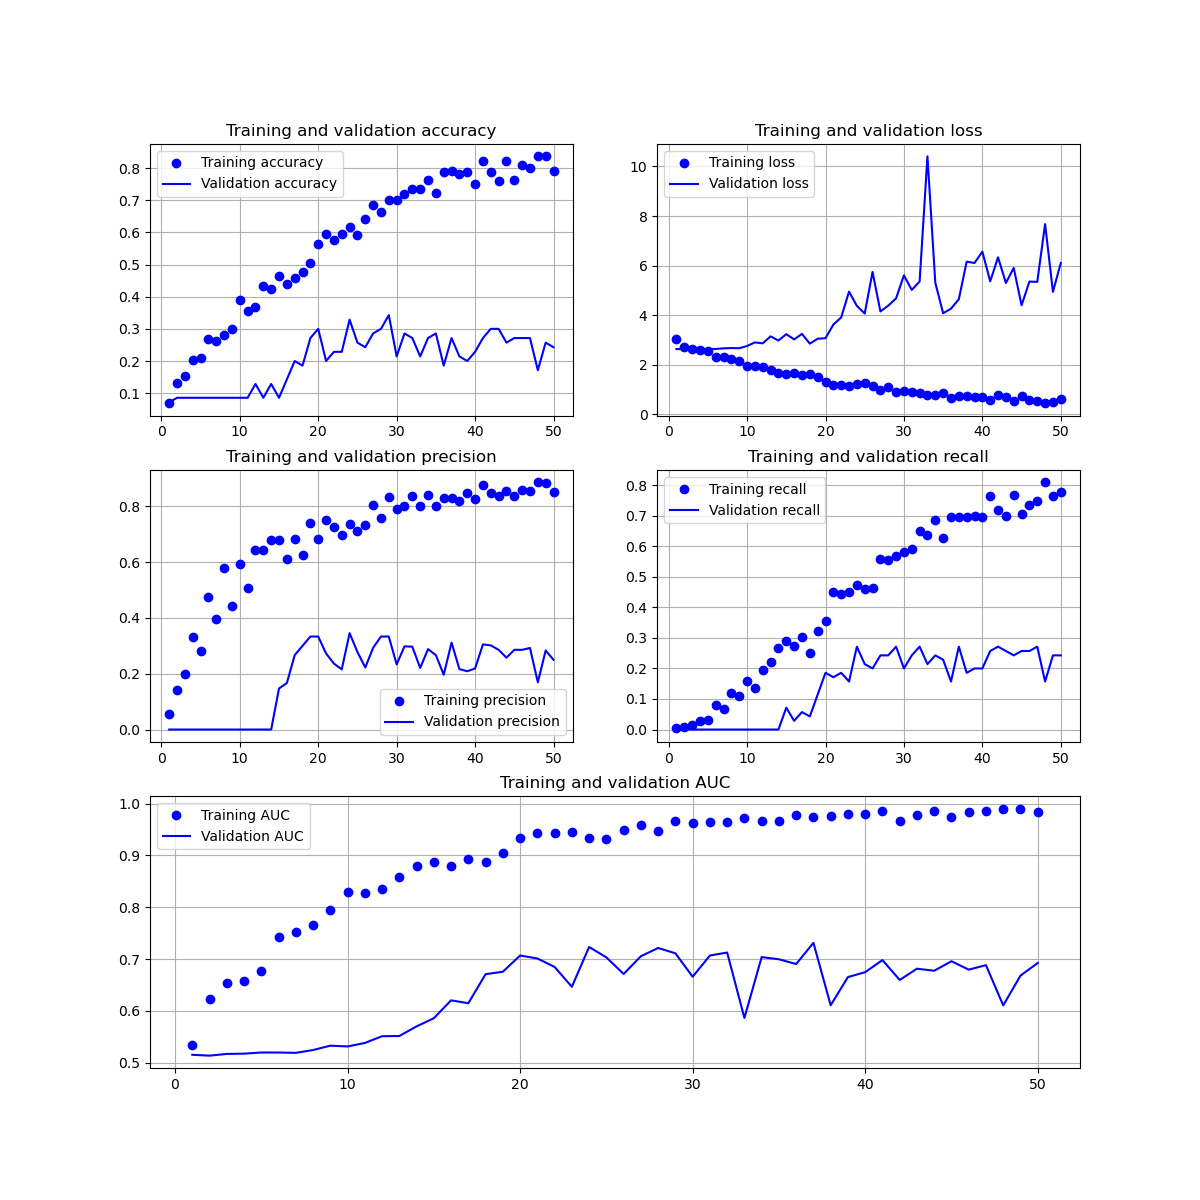

In [ ]:
plot_history(history)


In [5]:

test_model = keras.models.load_model(
    os.path.join(MODELS_DIR, 'modern_arch_ERS_MSCELEB_12Cat.keras'))
show_eval_results(test_model, validation_dataset)

2023-01-15 05:42:38.993265: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700
2023-01-15 05:42:46.007034: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-15 05:42:46.024328: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-01-15 05:42:46.024459: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-01-15 05:42:46.028190: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

3/6 [==============>...............] - ETA: 0s - loss: 0.4222 - accuracy: 0.8854 - auc: 0.9816 - precision: 0.8947 - recall: 0.8854  

2023-01-15 05:42:47.138909: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


6/6 [==============================] - 18s 150ms/step - loss: 0.2631 - accuracy: 0.9222 - auc: 0.9902 - precision: 0.9274 - recall: 0.9222
Test loss: 0.263
Test accuracy: 0.922
Test AUC: 0.990
Test Precision: 0.927
Test Recall: 0.922
